# Import

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import os

import package_LAB 
import package_DBR 

from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from package_LAB import * 


# Parameters

In [92]:
TSim = 3000
Ts = 1
N = int(TSim/Ts + 1)

#working point
MV0 = 50
DV0 = 50
PV0 = 65.11

#process
#-------
#parameters for input-output dynamics
Kp = 0.45114207269109724
T1p = 110.89766441155744
T2p = 20.20409707770138
thetap = 11.421940328176037

#parameters for disturbance dynamics
Kd = 0.39493489030424944
T1d = 176.54512623159854
T2d = 35.063342202231915
thetad = 14.280806053306666

#tuning of controller
gamma = 0.6
Kc, Ti, Td = IMCTuning(Kp,T1p,T2p,thetap,gamma)

alpha = 1

MVMin = 0
MVMax = 100


# Simulation inputs signals

In [93]:
## scenario 1: OLP + no FF
#ManPath = {0: True, TSim: True}
#MVManPath = {0: MV0, TSim: MV0}
#SPPath = {0: PV0, TSim: PV0}
#DVPath = {0: 50, 1300: 60, TSim: 60.0}
#ActivateFF = False
#ManFF = True

## scenario 2: OLP + FF
#ManPath = {0: True, TSim: True} 
#MVManPath = {0: MV0, TSim: MV0}
#SPPath = {0: PV0, TSim: PV0}
#DVPath = {0: 50.0, 1300: 60, TSim: 60.0}
#ActivateFF = True
#ManFF = True

## scenario 3: CLP + no FF
#ManPath = {0: True, 500: False, TSim: False} 
#MVManPath = {0: MV0, TSim: MV0}
#SPPath = {0: PV0+5, 1800: PV0-5, TSim: PV0-5}
#DVPath = {0: DV0, 2100: DV0+10, TSim: DV0+10}
#ActivateFF = False
#ManFF = False

## scenario 4: CLP + FF
ManPath = {0: True, 500: False, TSim: False}
MVManPath = {0: MV0, TSim: MV0}
SPPath = {0: PV0+5, 1800: PV0-5, TSim: PV0-5}
DVPath = {0: DV0, 2100: DV0+10, TSim: DV0+10}
ActivateFF = True
ManFF = False

# Closed-loop simulation with PID and FF

In [94]:
t = [] 
SP = []
PV = []
Man = []
MVMan = []
MVFF = []
MV = []
MVP = []
MVI = []
MVD = []
DV = []
E = []

MVFFDelay = []
MVFFLL1 = []

MVDelayp = []
PV1p = []
PV2p = []

MVDelayd = []
PV1d = []
PV2d = []

for i in range(0,N):
    t.append(i*Ts)

    #Input signals SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)

    #Feedforward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad - thetap,0]),Ts,MVFFDelay)
    LL_RT(MVFFDelay,-Kd/Kp, T1p, T1d, Ts, MVFFLL1)
    if ActivateFF:
        LL_RT(MVFFLL1,1,T2p,T2d,Ts,MVFF)
    else:
        LL_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)

    #PID Controller mode
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)

    #PID Controller action
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF)

    #input output dynamics P(s)
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)

    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kp,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    
    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0) 

MVP Empty
MVI Empty
MVD Empty


# Plot data

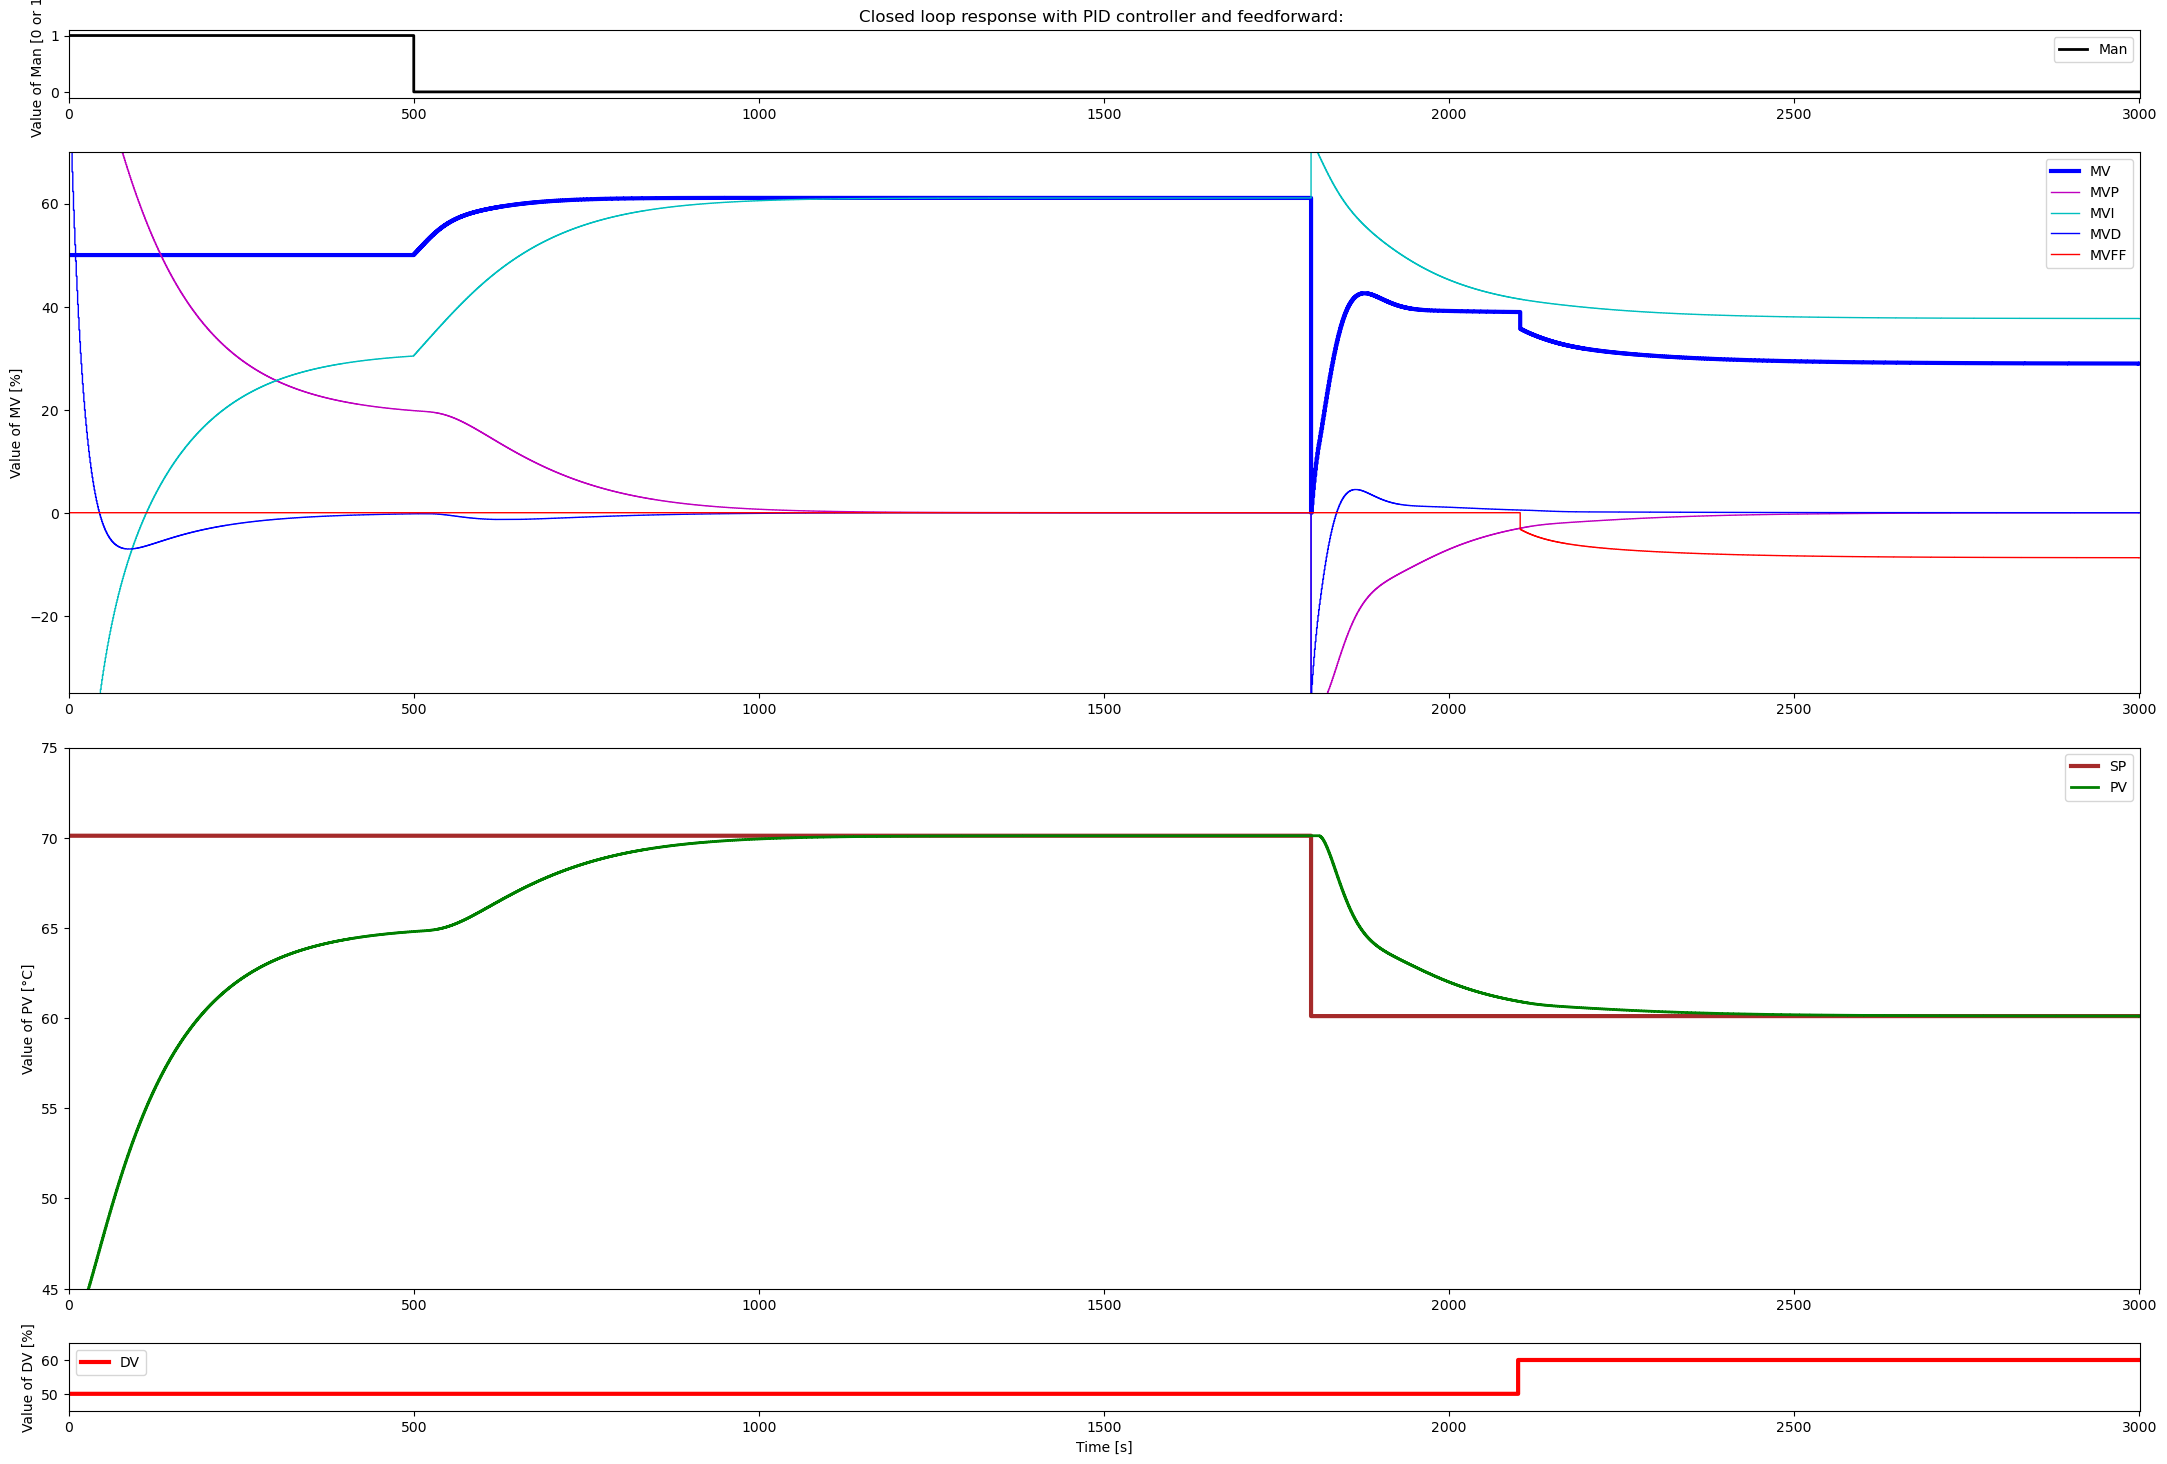

In [95]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, gridspec_kw={'height_ratios':[1,8,8,1]}) 
fig.set_figheight(15)
fig.set_figwidth(22)

l1, = ax1.step([0,TSim],[-0.1,1.1],'k-', linewidth=2, label='Man', where='post')
ax1.set_ylabel('Value of Man [0 or 1]')
ax1.set_title('Closed loop response with PID controller and feedforward: ')
ax1.legend(loc='best')

l2, = ax2.step([0,TSim],[0,100],'b-', linewidth=3, label='MV', where='post')
l3, = ax2.step([0,TSim],[0,100],'m-', linewidth=1, label='MVP', where='post')
l4, = ax2.step([0,TSim],[-0,100],'c-', linewidth=1, label='MVI', where='post')
l5, = ax2.step([0,TSim],[0,100],'b-', linewidth=1, label='MVD', where='post')
l6, = ax2.step([0,TSim],[0,100],'r-', linewidth=1, label='MVFF', where='post')
ax2.set_ylabel('Value of MV [%]')
ax2.legend(loc='best')

l7, = ax3.step([0,TSim],[0,100],'brown', linewidth=3, label='SP', where='post')
l8, = ax3.step([0,TSim],[0,100],'g-', linewidth=2, label='PV', where='post')
ax3.set_ylabel('Value of PV [°C]')
ax3.legend(loc='best')

l9, = ax4.step([0,TSim],[0,100],'r-', linewidth=3, label='DV', where='post')
ax4.set_ylabel('Value of DV [%]')
ax4.set_xlabel('Time [s]')
ax4.legend(loc='best')

ManInt = [int(x) for x in Man]

l1.set_data(t,Man)
l2.set_data(t,MV)
l3.set_data(t,MVP)
l4.set_data(t,MVI)
l5.set_data(t,MVD)
l6.set_data(t,MVFF)

l7.set_data(t,SP)
l8.set_data(t,PV)

l9.set_data(t,DV)

ax1.set_xlim(0, t[-1]+1)
ax2.set_xlim(0, t[-1]+1)
ax3.set_xlim(0, t[-1]+1)
ax4.set_xlim(0, t[-1]+1)

MVMinscope = myRound(np.min([np.min(MV),np.min(MVP),np.min(MVI),np.min(MVD),np.min(MVFF)]),5)-5
MVMaxscope = myRound(np.max([np.max(MV),np.max(MVP),np.max(MVI),np.max(MVD),np.max(MVFF)]),5)+5
fig.tight_layout(pad = 2.0)

ax1.set_ylim(-0.1,1.1)
ax2.set_ylim(np.max([MVMinscope,-35]),np.min([MVMaxscope,70]))
ax3.set_ylim(np.max([myRound(np.min((np.min(PV),np.min(SP))),5),-5,40]),myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5,myRound(np.max(DV),5)+5)

# Conversion to array
t =  np.array(t) 
MV = np.array(MV)
MVP = np.array(MVP)
MVI = np.array(MVI)
MVD = np.array(MVD)
PV = np.array(PV)
DV = np.array(DV) 
SP = np.array(SP)
Man = np.array(Man)
my_data = np.vstack((t.T,MV.T,MVP.T,MVI.T,MVD.T,PV.T,DV.T,SP.T,Man.T))
my_data = my_data.T
nameFile = 'Data/Simulation_CLP_FF_Auto' + '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,PV,DV,SP,Man',comments='')        

